In [1]:
#import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import * 

In [2]:
# load the data 
data = pd.read_csv("./BTC.csv" , parse_dates=["Date"] , index_col="Date" )
data = data.drop(columns="Crypto")
print("First 5 rows of data : \n",data.head())
print("Last 5 rows of data : \n",data.tail())

data.index = pd.to_datetime(data.index ,   format="%yyyy-%mm-%dd")
data = data.sort_index()

First 5 rows of data : 
               Open    High     Low   Close
Date                                      
2019-12-31  7254.0  7309.0  7132.0  7171.0
2019-12-30  7402.0  7430.0  7217.0  7254.0
2019-12-29  7334.0  7529.0  7295.0  7402.0
2019-12-28  7235.0  7359.0  7235.0  7334.0
2019-12-27  7208.0  7267.0  7087.0  7235.0
Last 5 rows of data : 
                Open     High      Low    Close
Date                                          
2022-01-07  43114.0  43233.0  40769.0  41908.0
2022-01-06  43658.0  43764.0  42529.0  43114.0
2022-01-05  46298.0  46851.0  43522.0  43658.0
2022-01-04  46055.0  47490.0  45586.0  46298.0
2022-01-03  47026.0  47544.0  45745.0  46055.0


C:\Users\arnol\AppData\Local\Temp\ipykernel_31348\610257892.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv("./BTC.csv" , parse_dates=["Date"] , index_col="Date" )


In [3]:
print(data.info())  # Column info & data types

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1974 entries, 2018-01-01 to 2023-05-31
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1974 non-null   float64
 1   High    1974 non-null   float64
 2   Low     1974 non-null   float64
 3   Close   1974 non-null   float64
dtypes: float64(4)
memory usage: 77.1 KB
None


In [4]:
print("Volume of data : " , data.shape)

Volume of data :  (1974, 4)


In [5]:
# handle duplicated values

data.drop_duplicates(inplace=True)
print("Duplicated values in data : ", data.duplicated().sum())

Duplicated values in data :  0


In [6]:
# handle missing values
print("missing values in data : ", data.isnull().sum())

missing values in data :  Open     0
High     0
Low      0
Close    0
dtype: int64


In [7]:
# Separate categorical and numerical columns

categorical_cols = data.select_dtypes(include=['object']).columns.tolist()
numerical_cols = data.select_dtypes(include=['number']).columns.tolist()

print("Categorical = ", categorical_cols)
print("Numerical = ",numerical_cols)

Categorical =  []
Numerical =  ['Open', 'High', 'Low', 'Close']


In [8]:
#########################       EDA ANALYTICS #########################

In [9]:
# Summary statistics of numerical columns
print("summary statistics  \n",data.describe().T)

summary statistics  
         count          mean           std     min     25%      50%      75%  \
Open   1973.0  20646.609731  16392.623868  3188.0  8019.0  11762.0  30960.0   
High   1973.0  21181.196148  16829.497753  3266.0  8219.0  12057.0  31920.0   
Low    1973.0  20071.843893  15901.396638  3156.0  7751.0  11518.0  29739.0   
Close  1973.0  20651.124683  16391.434681  3188.0  8019.0  11757.0  30991.0   

           max  
Open   67802.0  
High   68925.0  
Low    66112.0  
Close  67802.0  


In [10]:
#########feature engineering and indicators#########

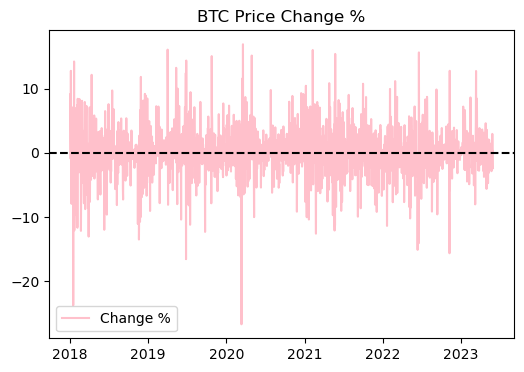

In [11]:
# price changes in %

data["change%"] =  data["Close"].pct_change() *100


# graph depicting the % change
plt.figure(figsize=(6,4))
plt.plot(data["change%"] , label="Change %" , color="pink")
plt.title("BTC Price Change %")
plt.axhline(y=0 , color="black" , linestyle="--")
plt.legend()
plt.show()

In [12]:
# calculate the moving average  > avg moving price over the time period
data["MA7"] = data["Close"].rolling(window=7).mean()
data["MA30"] = data["Close"].rolling(window=30).mean()
print(data.tail().T)


Date       2023-05-27    2023-05-28    2023-05-29    2023-05-30    2023-05-31
Open     26752.000000  26759.000000  27552.000000  27680.000000  27777.000000
High     26832.000000  27661.000000  28419.000000  28019.000000  27837.000000
Low      26629.000000  26747.000000  27537.000000  27573.000000  26884.000000
Close    26759.000000  27552.000000  27680.000000  27777.000000  27120.000000
change%      0.026166      2.963489      0.464576      0.350434     -2.365266
MA7      26771.571429  26871.142857  26983.285714  27063.428571  27160.142857
MA30     27648.133333  27588.200000  27534.333333  27481.966667  27462.466667


In [13]:
def compute_RSI(data, window=14):
    delta = data["Close"].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    RS = gain / loss
    return 100 - (100 / (1 + RS))

data["RSI_14"] = compute_RSI(data)
# Volatility: Standard Deviation of Close Price over 7-day window
data['Volatility_7'] = data['Close'].rolling(window=7).std()
# Average True Range (ATR) - Measures market volatility
data['ATR_14'] = (data['High'] - data['Low']).rolling(window=14).mean()

In [14]:
# Bollinger Bands 
#middle band
data["MidBand"] = data["MA30"]
# calculate the std deviation for rolling window
data["Std_Deviation"] = data["Close"].rolling(window=30).std()
#lower and upper band
data["LowerBand"] = data["MidBand"] -( 2 * data["Std_Deviation"])
data["UpperBand"] = data["MidBand"] + ( 2 * data["Std_Deviation"])
# Drop NaN values (caused by rolling calculations)
data.dropna(inplace=True)


In [15]:
# Define trend as 1 if next day’s closing price is higher, else 0.
data['Trend'] = np.where(data['Close'].shift(-1) > data['Close'], 1, 0)
# Remove the last row as it does not have a next day value
data = data.dropna()

In [16]:
print("Overview of dataset after adding some features \n\n" , data.head())

Overview of dataset after adding some features 

                Open     High     Low    Close   change%           MA7  \
Date                                                                    
2018-01-30  11224.0  11224.0  9810.0  10138.0 -9.667647  11146.428571   
2018-01-31  10125.0  10334.0  9628.0   9999.0 -1.371079  10973.714286   
2018-02-01   9999.0  10203.0  8564.0   9146.0 -8.530853  10673.714286   
2018-02-02   9146.0   9164.0  7695.0   8524.0 -6.800787  10334.428571   
2018-02-03   8588.0   9471.0  8176.0   9157.0  7.426091   9992.000000   

                    MA30     RSI_14  Volatility_7       ATR_14       MidBand  \
Date                                                                           
2018-01-30  12968.366667  47.403231    522.275425  1314.214286  12968.366667   
2018-01-31  12850.500000  41.983490    675.847546  1182.428571  12850.500000   
2018-02-01  12663.033333  37.111183    946.662508  1200.857143  12663.033333   
2018-02-02  12445.266667  35.664046   

In [17]:
# feature selection
x = data[["High", "Low", "Open" , "MA7" , "MA30" , "ATR_14" , "Trend"]]
y = data["Close"]

print("X features \n " , x.head())
print("Y features \n " , y.head())

X features 
                 High     Low     Open           MA7          MA30       ATR_14  \
Date                                                                            
2018-01-30  11224.0  9810.0  11224.0  11146.428571  12968.366667  1314.214286   
2018-01-31  10334.0  9628.0  10125.0  10973.714286  12850.500000  1182.428571   
2018-02-01  10203.0  8564.0   9999.0  10673.714286  12663.033333  1200.857143   
2018-02-02   9164.0  7695.0   9146.0  10334.428571  12445.266667  1236.785714   
2018-02-03   9471.0  8176.0   8588.0   9992.000000  12253.133333  1203.428571   

            Trend  
Date               
2018-01-30      0  
2018-01-31      0  
2018-02-01      0  
2018-02-02      1  
2018-02-03      0  
Y features 
  Date
2018-01-30    10138.0
2018-01-31     9999.0
2018-02-01     9146.0
2018-02-02     8524.0
2018-02-03     9157.0
Name: Close, dtype: float64


In [18]:
xtrain, xtest, ytrain , ytest = train_test_split(x , y , test_size=0.3 , random_state=42 , shuffle=False)

In [19]:
# model building
xgb_model = XGBRegressor(n_estimators=75 , learning_rate=0.3 , random_state=42)
xgb_model.fit(xtrain , ytrain)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=75, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [20]:

# prediction
pred_xgb = xgb_model.predict(xtest)

# model evaluation
mae_xgb = mean_absolute_error(ytest, pred_xgb)
print("Mean Absolute Error (MAE) for XGBoost Model: ", mae_xgb)
r2_xgb = r2_score(ytest, pred_xgb)
print("R2 score for XGBoost Model: ", r2_xgb)

Mean Absolute Error (MAE) for XGBoost Model:  942.7107100813356
R2 score for XGBoost Model:  0.9913060904843175


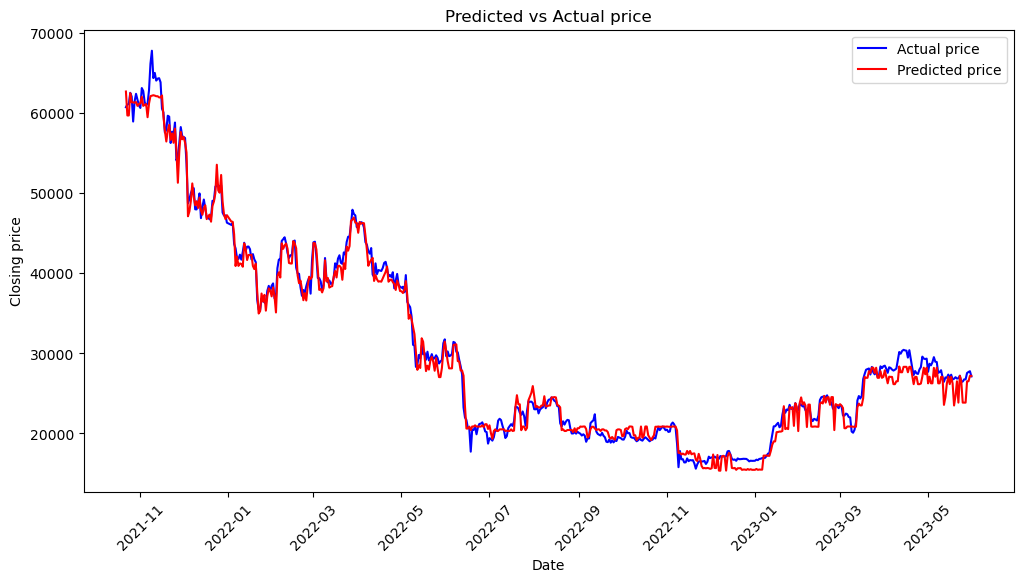

In [21]:
# visualization of predicated vs actual results
plt.figure(figsize=(12,6))
plt.plot(data.index[-len(ytest):] ,ytest , label ="Actual price" , color = "Blue" )
plt.plot(data.index[-len(ytest):] ,pred_xgb , label ="Predicted price" , color = "Red" )
plt.xlabel("Date")
plt.ylabel("Closing price")
plt.title("Predicted vs Actual price")
plt.legend()
plt.xticks(rotation = 45)
plt.show()